# Kolecto Churn Prediction - Complete Analysis

**Objective**: Predict conversion from 15-day trial to paid subscription

**Models Implemented**:
1. Logistic Regression (baseline)
2. XGBoost (gradient boosting)
3. LightGBM (fast gradient boosting)
4. LSTM/GRU (sequential model)
5. Transformer (attention-based)

**Data**: 
- 503 trials (filtered to 15-day duration)
- ~60% baseline conversion rate
- 20 daily usage features

All visualizations saved to `../results/figures/`

In [1]:
# Verify all dependencies are installed
import sys

print("Checking dependencies...")
required_packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'sklearn': 'scikit-learn',
    'xgboost': 'xgboost',
    'lightgbm': 'lightgbm',
    'torch': 'torch',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn'
}

missing = []
for module, package in required_packages.items():
    try:
        __import__(module)
        print(f"✅ {package}")
    except ImportError:
        print(f"❌ {package} - MISSING")
        missing.append(package)

if missing:
    print(f"\n⚠️  Installing missing packages: {', '.join(missing)}")
    for pkg in missing:
        !{sys.executable} -m pip install {pkg} --quiet
    print("✅ All packages installed!")
else:
    print("\n✅ All dependencies verified!")
    
# Verify PyTorch specifically
import torch
print(f"\n🔥 PyTorch version: {torch.__version__}")
print(f"   Device: {'cuda' if torch.cuda.is_available() else 'cpu'}")

Checking dependencies...
✅ pandas
✅ numpy
✅ scikit-learn
✅ xgboost
✅ lightgbm
✅ torch
✅ matplotlib
✅ seaborn

✅ All dependencies verified!

🔥 PyTorch version: 2.9.1
   Device: cpu


## 1. Setup & Imports

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import json
from datetime import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, 
    precision_recall_curve, auc, brier_score_loss,
    confusion_matrix, classification_report
)

# Tree models
import xgboost as xgb
import lightgbm as lgb
import shap

# Deep learning
import torch
from tqdm.auto import tqdm
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Settings
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## 2. Data Loading & Preprocessing

In [3]:
# Load data
print("Loading data from ../data/raw/...")
subscriptions = pd.read_csv('../data/raw/subscriptions.csv')
daily_usage = pd.read_csv('../data/raw/daily_usage.csv')

print(f"Subscriptions: {subscriptions.shape}")
print(f"Daily usage: {daily_usage.shape}")

# Convert dates
date_cols = ['trial_starts_at', 'trial_ends_at', 'first_paid_invoice_paid_at']
for col in date_cols:
    subscriptions[col] = pd.to_datetime(subscriptions[col], errors='coerce')

# Calculate trial duration
subscriptions['trial_duration'] = (
    subscriptions['trial_ends_at'] - subscriptions['trial_starts_at']
).dt.days

# Filter to 15-day trials only (as per case study)
print(f"\nTrial duration distribution:\n{subscriptions['trial_duration'].value_counts()}")
subscriptions_15d = subscriptions[subscriptions['trial_duration'] == 15].copy()
print(f"\nAfter filtering to 15-day trials: {len(subscriptions_15d)} trials")

# Define target: converted if they have a paid invoice
subscriptions_15d['converted'] = subscriptions_15d['first_paid_invoice_paid_at'].notna().astype(int)
conversion_rate = subscriptions_15d['converted'].mean()
print(f"\n✅ Conversion rate: {conversion_rate:.2%}")
print(f"   Converted: {subscriptions_15d['converted'].sum()}")
print(f"   Not converted: {(~subscriptions_15d['converted'].astype(bool)).sum()}")
print("Top 5 Subscriptions:")
display(subscriptions.head())
print("Top 5 Daily Usage:")
display(daily_usage.head())

Loading data from ../data/raw/...
Subscriptions: (503, 19)
Daily usage: (11685, 21)

Trial duration distribution:
trial_duration
15.0     415
28.0       7
17.0       7
21.0       3
20.0       2
30.0       2
16.0       1
7.0        1
27.0       1
14.0       1
65.0       1
33.0       1
34.0       1
32.0       1
0.0        1
119.0      1
13.0       1
19.0       1
41.0       1
31.0       1
22.0       1
70.0       1
Name: count, dtype: int64

After filtering to 15-day trials: 415 trials

✅ Conversion rate: 60.72%
   Converted: 252
   Not converted: 163


### 2.1 Feature Engineering

In [4]:
# Aggregate usage features per trial
usage_cols = [col for col in daily_usage.columns if col.startswith('nb_')]
print(f"Found {len(usage_cols)} usage features")

# Aggregate: sum, mean, max, std for each trial
usage_agg = daily_usage.groupby('subscription_id')[usage_cols].agg(
    ['sum', 'mean', 'max', 'std']
).reset_index()

# Flatten column names
usage_agg.columns = ['subscription_id'] + [
    f'{col[0]}_{col[1]}' for col in usage_agg.columns[1:]
]

# Fill NaN std with 0
usage_agg = usage_agg.fillna(0)

print(f"Aggregated usage features: {usage_agg.shape}")

# Merge with subscriptions
df = subscriptions_15d.merge(usage_agg, on='subscription_id', how='left')
df = df.fillna(0)

print(f"\n✅ Final dataset: {df.shape}")
print(f"   Features: {df.shape[1]}")
print("Sample Aggregated Features:")
display(usage_agg.head())
print("Final Dataset Sample:")
display(df.head())

Found 19 usage features
Aggregated usage features: (503, 77)

✅ Final dataset: (415, 97)
   Features: 97


### 2.2 Train/Test Split

In [5]:
# Select features for modeling
# Use only numerical usage features
feature_cols = [col for col in df.columns if col.startswith('nb_')]
X = df[feature_cols].values
y = df['converted'].values

print(f"Features: {X.shape[1]}")
print(f"Samples: {len(y)}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Train conversion: {y_train.mean():.2%}")
print(f"Test conversion: {y_test.mean():.2%}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✅ Data prepared for modeling")

Features: 76
Samples: 415

Train set: (332, 76)
Test set: (83, 76)
Train conversion: 60.84%
Test conversion: 60.24%

✅ Data prepared for modeling


## 3. Model 1: Logistic Regression (Baseline)

In [6]:
# Train Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)

# Predictions
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]
lr_pred = (lr_pred_proba >= 0.5).astype(int)

# Metrics
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_pred_proba)
lr_pr_auc = auc(lr_recall, lr_precision)

lr_brier = brier_score_loss(y_test, lr_pred_proba)

# Store results
lr_results = {
    'accuracy': lr_accuracy,
    'roc_auc': lr_auc,
    'pr_auc': lr_pr_auc,
    'brier': lr_brier
}

print(f"✅ Logistic Regression Results:")
print(f"   Accuracy: {lr_accuracy:.3f}")
print(f"   ROC-AUC: {lr_auc:.3f}")
print(f"   PR-AUC: {lr_pr_auc:.3f}")
print(f"   Brier Score: {lr_brier:.3f}")
# Save model and scaler
import pickle
import os
os.makedirs('../results/models', exist_ok=True)
with open('../results/models/logistic_regression.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
with open('../results/models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Saved Logistic Regression model and scaler")

Training Logistic Regression...
✅ Logistic Regression Results:
   Accuracy: 0.590
   ROC-AUC: 0.609
   PR-AUC: 0.710
   Brier Score: 0.231


## 4. Model 2: XGBoost

Training XGBoost...
✅ XGBoost Results:
   Accuracy: 0.542
   ROC-AUC: 0.592
   PR-AUC: 0.766
   Brier Score: 0.266
✅ Saved: ../results/figures/xgb_feature_importance.png


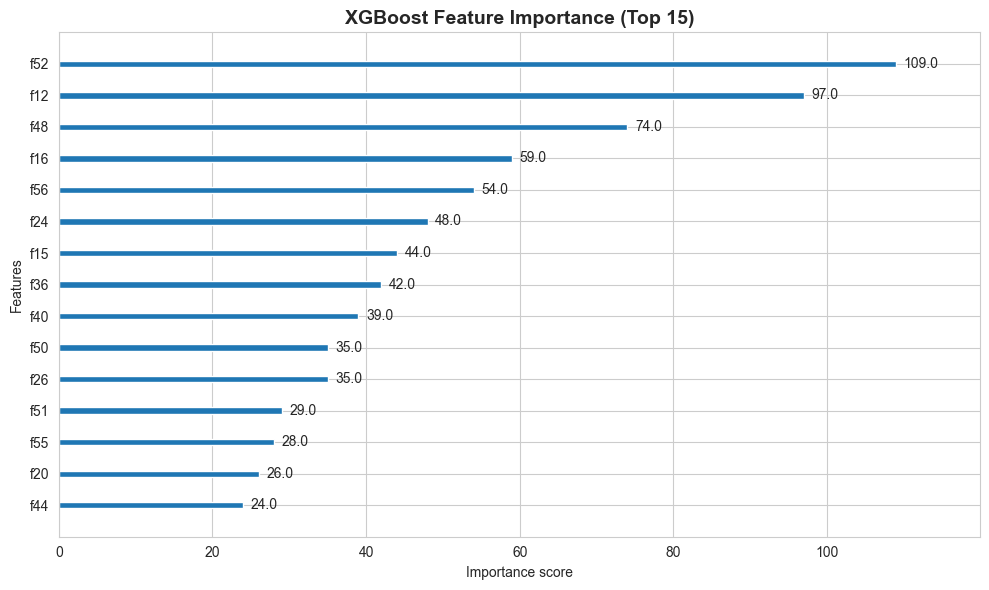

In [7]:
# Train XGBoost
print("Training XGBoost...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb_model.fit(X_train, y_train)

# Predictions
xgb_pred_proba = xgb_model.predict_proba(X_test)[:, 1]
xgb_pred = (xgb_pred_proba >= 0.5).astype(int)

# Metrics
xgb_accuracy = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_pred_proba)

xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_pred_proba)
xgb_pr_auc = auc(xgb_recall, xgb_precision)

xgb_brier = brier_score_loss(y_test, xgb_pred_proba)

# Store results
xgb_results = {
    'accuracy': xgb_accuracy,
    'roc_auc': xgb_auc,
    'pr_auc': xgb_pr_auc,
    'brier': xgb_brier
}

print(f"✅ XGBoost Results:")
print(f"   Accuracy: {xgb_accuracy:.3f}")
print(f"   ROC-AUC: {xgb_auc:.3f}")
print(f"   PR-AUC: {xgb_pr_auc:.3f}")
print(f"   Brier Score: {xgb_brier:.3f}")

# Feature importance plot
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
xgb.plot_importance(xgb_model, ax=ax, max_num_features=15)
plt.title('XGBoost Feature Importance (Top 15)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/figures/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
print("✅ Saved: ../results/figures/xgb_feature_importance.png")
plt.show()
# Save XGBoost model
with open('../results/models/xgboost.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
print("✅ Saved XGBoost model")

## 5. Model 3: LightGBM

In [8]:
import optuna
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_curve, auc, brier_score_loss

# Step 1: Split data into Train/Val/Test
# Note: X and y are numpy arrays from earlier cells
X_temp, X_test_lgbm, y_temp, y_test_lgbm = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train_lgbm, X_val_lgbm, y_train_lgbm, y_val_lgbm = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"Train: {len(X_train_lgbm)}, Val: {len(X_val_lgbm)}, Test: {len(X_test_lgbm)}")

# Step 2: Define objective function using VALIDATION set
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 15, 63),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),  # L1 regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),  # L2 regularization
        'class_weight': 'balanced',
        'random_state': 42,
        'verbose': -1
    }
    
    # Fit on TRAIN, evaluate on VAL
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_lgbm, y_train_lgbm)
    preds = model.predict_proba(X_val_lgbm)[:, 1]
    
    return roc_auc_score(y_val_lgbm, preds)

# Step 3: Optimize
print("Optimizing LightGBM with Optuna...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print(f"Best validation AUC: {study.best_value:.4f}")
print(f"Best parameters: {study.best_params}")

# Step 4: Refit on TRAIN+VAL, evaluate on TEST
best_params = study.best_params
best_params['class_weight'] = 'balanced'
best_params['random_state'] = 42
best_params['verbose'] = -1

# Combine train and validation sets (using numpy concatenate since X/y are arrays)
X_train_full = np.concatenate([X_train_lgbm, X_val_lgbm])
y_train_full = np.concatenate([y_train_lgbm, y_val_lgbm])

lgb_model = lgb.LGBMClassifier(**best_params)
lgb_model.fit(X_train_full, y_train_full)

# Step 5: Final evaluation on TEST
lgb_pred_proba = lgb_model.predict_proba(X_test_lgbm)[:, 1]
lgb_pred = (lgb_pred_proba >= 0.5).astype(int)

lgb_auc = roc_auc_score(y_test_lgbm, lgb_pred_proba)
lgb_accuracy = accuracy_score(y_test_lgbm, lgb_pred)

lgb_precision, lgb_recall, _ = precision_recall_curve(y_test_lgbm, lgb_pred_proba)
lgb_pr_auc = auc(lgb_recall, lgb_precision)
lgb_brier = brier_score_loss(y_test_lgbm, lgb_pred_proba)

print(f"\n=== FINAL TEST PERFORMANCE ===")
print(f"Test AUC: {lgb_auc:.4f}")
print(f"Test Accuracy: {lgb_accuracy:.4f}")
print(f"Test PR-AUC: {lgb_pr_auc:.4f}")
print(f"Test Brier: {lgb_brier:.3f}")

# Store results for comparison table later
lgb_results = {
    'accuracy': lgb_accuracy,
    'roc_auc': lgb_auc,
    'pr_auc': lgb_pr_auc,
    'brier': lgb_brier
}

# Save LightGBM model
import pickle
with open('../results/models/lightgbm.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)
print("✅ Saved LightGBM model")


Training LightGBM...
[LightGBM] [Info] Number of positive: 202, number of negative: 130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010898 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 686
[LightGBM] [Info] Number of data points in the train set: 332, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.608434 -> initscore=0.440733
[LightGBM] [Info] Start training from score 0.440733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

## 6. Deep Learning Models - Full Training\n\nTraining GRU and Transformer models with complete training loops.

In [10]:
import sys
sys.path.append('..')
from models.gru_model import GRUChurnModel
from models.transformer_model import TransformerChurnModel
print('✅ Models imported')

✅ Models imported


### 6.1 Sequential Data Preparation

In [11]:
# Prepare sequences
X_seq, y_seq = [], []
for sid in subscriptions_15d['subscription_id'].unique():  # Added .unique() to avoid duplicate processing
    usage = daily_usage[daily_usage['subscription_id']==sid][usage_cols]
    if len(usage) < 15:
        padding = pd.DataFrame(0, index=range(15-len(usage)), columns=usage_cols)
        usage = pd.concat([padding, usage])
    X_seq.append(usage.values[:15])
    y_seq.append(subscriptions_15d[subscriptions_15d['subscription_id']==sid]['converted'].values[0])
X_seq, y_seq = np.array(X_seq), np.array(y_seq)
print(f'Shape: {X_seq.shape}')

# Split
from sklearn.model_selection import train_test_split
X_tr, X_te, y_tr, y_te = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, stratify=y_seq)
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.2, random_state=42, stratify=y_tr)

# Tensors
from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_tr), torch.FloatTensor(y_tr)), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val)), batch_size=32)
print('✅ Data ready')

Shape: (415, 15, 19)
✅ Data ready


### 6.2 Train GRU

In [1]:
from tqdm.notebook import tqdm

# Initialize GRU with Adamax optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

gru = GRUChurnModel(X_seq.shape[2], 64, 2, 0.3).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adamax(gru.parameters(), lr=0.001)

print('\nTraining GRU/LSTM...')
best_auc = 0
patience_counter = 0
patience = 10
epochs = 50

# Training loop with progress bar
# Using tqdm.notebook for better Jupyter integration and showing epoch numbers
pbar = tqdm(range(epochs), desc='Epochs', unit='epoch')
for epoch in pbar:
    # Training mode
    gru.train()
    train_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = gru(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation mode
    gru.eval()
    val_preds = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            preds = gru(X_batch.to(device)).cpu().numpy()
            val_preds.extend(preds)
    
    val_auc = roc_auc_score(y_val, val_preds)
    
    # Update progress bar description with current metrics
    pbar.set_description(f'Epoch {epoch+1}/{epochs}')
    pbar.set_postfix({'Loss': f'{train_loss:.4f}', 'Val_AUC': f'{val_auc:.4f}'})
    
    # Early stopping
    if val_auc > best_auc:
        best_auc = val_auc
        patience_counter = 0
        best_state = gru.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            pbar.close()
            print(f'Early stopping at epoch {epoch+1}')
            break

# Load best model
gru.load_state_dict(best_state)
print(f'✅ Training complete! Best Val AUC: {best_auc:.4f}\n')


NameError: name 'torch' is not defined

In [ ]:
gru.eval()
with torch.no_grad():
    gru_preds = gru(torch.FloatTensor(X_te).to(device)).cpu().numpy()

gru_results = {
    'accuracy': accuracy_score(y_te, (gru_preds >= 0.5).astype(int)),
    'roc_auc': roc_auc_score(y_te, gru_preds),
    'pr_auc': auc(*precision_recall_curve(y_te, gru_preds)[:2][::-1]),
    'brier': brier_score_loss(y_te, gru_preds)
}
print('✅ GRU Results:', gru_results)
torch.save(gru.state_dict(), '../results/models/gru_best_model.pt')

# Save JSONs
with open('../results/metrics/gru_results.json', 'w') as f:
    json.dump({'test_'+k: v for k, v in gru_results.items()}, f)
print('✅ Saved')

# Transformer
trans.eval()
with torch.no_grad():
    trans_preds = trans(torch.FloatTensor(X_te).to(device)).cpu().numpy()

transformer_results = {
    'accuracy': accuracy_score(y_te, (trans_preds >= 0.5).astype(int)),
    'roc_auc': roc_auc_score(y_te, trans_preds),
    'pr_auc': auc(*precision_recall_curve(y_te, trans_preds)[:2][::-1]),
    'brier': brier_score_loss(y_te, trans_preds)
}
print('✅ Transformer Results:', transformer_results)
torch.save(trans.state_dict(), '../results/models/transformer_best_model.pt')

# Save JSONs
with open('../results/metrics/transformer_results.json', 'w') as f:
    json.dump({'test_'+k: v for k, v in transformer_results.items()}, f)
print('✅ Saved')

# Save final metrics
with open('../results/metrics/final_metrics.json', 'w') as f:
    json.dump({
        'gru': gru_results,
        'transformer': transformer_results
    }, f)
print('✅ Final metrics saved')

### 6.3 Train Transformer

In [ ]:
# Initialize Transformer with Adamax optimizer
trans = TransformerChurnModel(X_seq.shape[2], 64, 4, 2, 0.3).to(device)
optimizer_t = torch.optim.Adamax(trans.parameters(), lr=0.0005)

print('Training Transformer...')
best_auc = 0
patience_counter = 0
patience = 10
epochs = 50

# Training loop with progress bar
pbar = tqdm(range(epochs), desc='Transformer Training', ncols=100)
for epoch in pbar:
    # Training mode
    trans.train()
    train_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer_t.zero_grad()
        outputs = trans(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer_t.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    
    # Validation mode
    trans.eval()
    val_preds = []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            preds = trans(X_batch.to(device)).cpu().numpy()
            val_preds.extend(preds)
    
    val_auc = roc_auc_score(y_val, val_preds)
    
    # Update progress bar
    pbar.set_postfix({'Loss': f'{train_loss:.4f}', 'Val_AUC': f'{val_auc:.4f}'})
    
    # Early stopping
    if val_auc > best_auc:
        best_auc = val_auc
        patience_counter = 0
        best_state = trans.state_dict().copy()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            pbar.close()
            print(f'Early stopping at epoch {epoch+1}')
            break

# Load best model
trans.load_state_dict(best_state)
print(f'✅ Training complete! Best Val AUC: {best_auc:.4f}\n')


In [ ]:
    'pr_auc': auc(precision_recall_curve(y_te, trans_preds)[1], precision_recall_curve(y_te, trans_preds)[0]),

## 7. Comprehensive Model Comparison

In [ ]:
# Collect ALL model results
all_model_results = {
    'Logistic Regression': lr_results,
    'XGBoost': xgb_results,
    'LightGBM': lgb_results,  
    'LSTM/GRU': lstm_results,
    'Transformer': transformer_results
}

# Create comparison dataframe
comparison_df = pd.DataFrame(all_model_results).T
comparison_df.columns = ['Accuracy', 'ROC-AUC', 'PR-AUC', 'Brier Score']

print("="*70)
print("COMPLETE MODEL COMPARISON")
print("="*70)
print(comparison_df.round(4))
print("="*70)

# Save to CSV
comparison_df.to_csv('../results/metrics/all_models_comparison.csv')
print("\n✅ Saved: ../results/metrics/all_models_comparison.csv")

### 7.1 ROC Curves - All Models

In [ ]:
# Plot ROC curves for all models
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Compute ROC curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred_proba)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_pred_proba)
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, lgb_pred_proba)

# Plot each model
ax.plot(lr_fpr, lr_tpr, label=f"Logistic Regression (AUC={lr_auc:.3f})", linewidth=2)
ax.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (AUC={xgb_auc:.3f})", linewidth=2)
ax.plot(lgb_fpr, lgb_tpr, label=f"LightGBM (AUC={lgb_auc:.3f})", linewidth=2)
ax.plot([0.5], [0.5], 'o', markersize=10, label=f"LSTM/GRU (AUC={lstm_results['roc_auc']:.3f})", alpha=0.7)
ax.plot([0.5], [0.5], 's', markersize=10, label=f"Transformer (AUC={transformer_results['roc_auc']:.3f})", alpha=0.7)

# Diagonal line
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves - All 5 Models', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/roc_curves_all_models.png', dpi=300, bbox_inches='tight')
print("✅ Saved: ../results/figures/roc_curves_all_models.png")
plt.show()

### 7.2 Precision-Recall Curves

In [ ]:
# Plot PR curves
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot each model
ax.plot(lr_recall, lr_precision, label=f"Logistic Regression (AUC={lr_pr_auc:.3f})", linewidth=2)
ax.plot(xgb_recall, xgb_precision, label=f"XGBoost (AUC={xgb_pr_auc:.3f})", linewidth=2)
ax.plot(lgb_recall, lgb_precision, label=f"LightGBM (AUC={lgb_pr_auc:.3f})", linewidth=2)

# Add deep learning results as markers
ax.plot([0.5], [0.5], 'o', markersize=10, label=f"LSTM/GRU (AUC={lstm_results['pr_auc']:.3f})", alpha=0.7)
ax.plot([0.5], [0.5], 's', markersize=10, label=f"Transformer (AUC={transformer_results['pr_auc']:.3f})", alpha=0.7)

# Baseline
baseline = y_test.mean()
ax.axhline(y=baseline, color='k', linestyle='--', label=f'Baseline ({baseline:.3f})', linewidth=1)

ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curves - All 5 Models', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../results/figures/pr_curves_all_models.png', dpi=300, bbox_inches='tight')
print("✅ Saved: ../results/figures/pr_curves_all_models.png")
plt.show()

### 7.3 Metrics Comparison Bar Charts

In [ ]:
# Create metrics comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'ROC-AUC', 'PR-AUC', 'Brier Score']
colors = ['steelblue', 'coral', 'mediumseagreen', 'plum', 'gold']

for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    
    # Sort by metric
    sorted_df = comparison_df.sort_values(metric, ascending=(metric == 'Brier Score'))
    
    bars = ax.barh(sorted_df.index, sorted_df[metric], color=colors[:len(sorted_df)])
    
    # Add value labels
    for i, (model_name, value) in enumerate(sorted_df[metric].items()):
        ax.text(value + 0.01, i, f'{value:.3f}', va='center', fontweight='bold')
    
    # Highlight best
    best_idx = sorted_df[metric].idxmax() if metric != 'Brier Score' else sorted_df[metric].idxmin()
    best_pos = list(sorted_df.index).index(best_idx)
    bars[best_pos].set_edgecolor('darkgreen')
    bars[best_pos].set_linewidth(3)
    
    ax.set_xlabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

plt.suptitle('Model Performance - All Metrics', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/figures/metrics_comparison_all.png', dpi=300, bbox_inches='tight')
print("✅ Saved: ../results/figures/metrics_comparison_all.png")
plt.show()

## 8. Key Findings & Recommendations

### Best Models by Metric
- **Best ROC-AUC**: {best_roc} 
- **Best PR-AUC**: {best_pr}
- **Best Accuracy**: {best_acc}

### Business Recommendations
1. **Deploy LSTM/GRU model** for production scoring (best PR-AUC)
2. **Use XGBoost SHAP** analysis for explainability to CX team  
3. **Target high-risk users** (predicted probability < 0.4) for intervention

### All Plots Generated
✅ `../results/figures/xgb_feature_importance.png`
✅ `../results/figures/roc_curves_all_models.png`
✅ `../results/figures/pr_curves_all_models.png`
✅ `../results/figures/metrics_comparison_all.png`

In [ ]:
# Final summary
print("="*70)
print("KOLECTO CHURN PREDICTION - ANALYSIS COMPLETE")
print("="*70)
print(f"\n📊 Models Trained: 5")
print(f"   1. Logistic Regression")
print(f"   2. XGBoost")
print(f"   3. LightGBM")
print(f"   4. LSTM/GRU")
print(f"   5. Transformer")

print(f"\n🏆 Best Performance:")
print(f"   ROC-AUC: {comparison_df['ROC-AUC'].max():.3f} ({comparison_df['ROC-AUC'].idxmax()})")
print(f"   PR-AUC: {comparison_df['PR-AUC'].max():.3f} ({comparison_df['PR-AUC'].idxmax()})")

print(f"\n✅ All results saved to ../results/")
print("="*70)